In [1]:
import numpy as np
from functools import partial
from scipy.stats import bernoulli
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.linalg 
from typing import Callable

import KF_Library as kf

# Model parameters

In [2]:
l = 10
T = 100*l 
t1 = np.arange(T)
A = np.array([[0.8499, 0.0350, 0.0240, 0.0431],
              [1.2081, 0.0738, 0.0763, 0.4087],
              [0.7331, 0.0674, 0.0878, 0.8767],
              [0.0172, 0.0047, 0.0114, 0.9123]])

B = np.array([[0, 0, 0, 1]])
C = np.array([[1, 0, 0, 0],
              [0, 0, 0, 1]])
Q = np.eye(4)
R = np.eye(2)


nx = np.shape(Q)[0]
ny = np.shape(R)[0]
q = 0.5*np.random.multivariate_normal(np.zeros(nx), Q, T)
r = 0.5*np.random.multivariate_normal(np.zeros(ny), R,  T//l)


# Initialization

In [3]:
x_init = np.array([0., 0., 0., 0.])
cov_init = np.diag([1., 1., 1., 1.])

# Model simulation

In [4]:
x = np.zeros((T,nx))
h = np.zeros((T//l,nx))
y = np.zeros((T//l,ny))
x[0] = x_init
for i in range(1,T):
    x[i] = A @ x[i-1] + q[i-1]
    if i%l == 0:
#         print(x[i-l+1:i+1, :])
        h[i//l ] = 1/l * np.sum(x[i-l+1:i+1, :], axis=0)
        y[i//l ] = C @ h[i//l ] + r[i//l ]


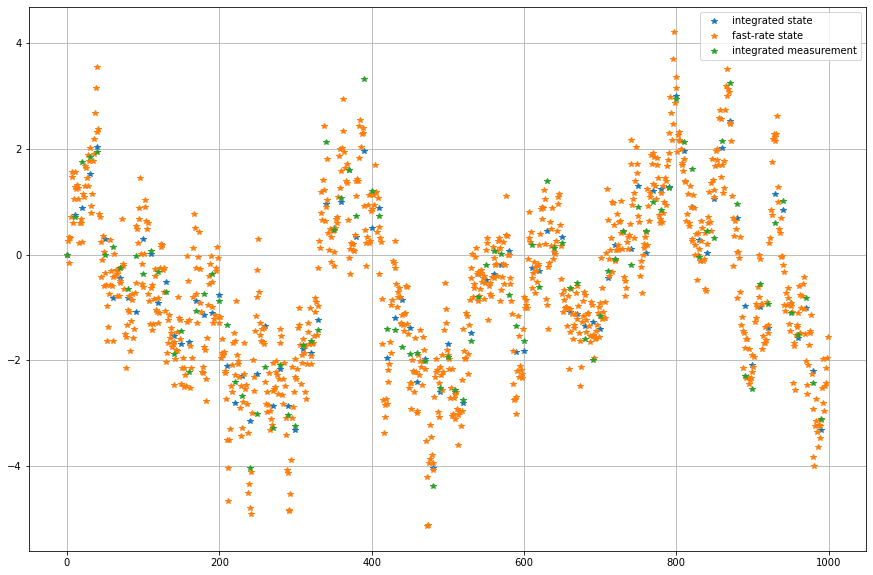

In [5]:
plt.figure(figsize = (15,10))

plt.plot(np.arange(0,T,l),h[:,0],'*',label = 'integrated state')
plt.plot(np.arange(T),x[:,0],'*',label = 'fast-rate state')
plt.plot(np.arange(0,T,l),y[:,0],'*',label = 'integrated measurement')
plt.legend()
plt.grid()

# Model simulation for Kalman Filter ($l$=1)

In [ ]:
nx = 4
ny = 2
steps = T
m0 = x_init # Suitable initial mean
P0 = cov_init # Suitable initial covariance

LQ = linalg.cholesky(Q, lower=True)
L0 = linalg.cholesky(P0, lower=True)

T1 = np.zeros((steps,))
X = np.zeros((steps,nx))
Y = np.zeros((steps,ny))

x_kf_test = m0 + L0 @ np.random.normal(size=(m0.shape))
t = 0

for n in range(steps):
    q = 0.5 * LQ @ np.random.normal(size=x_kf_test.shape)
    x = A @ x_kf_test + q
    r = 0.5 * np.random.normal()
    y = C @ x_kf_test + r
    t = t + dt
    T1[n] = t
    X[n,:] = x_kf_test
    Y[n,:] = y

plt.clf()
plt.plot(T1,X[:,0],T1,Y[:,0],'.',T1,X[:,1],':')
plt.legend(['p','y','dp/dt'])


# IMKF

In [6]:
x_hat = np.zeros((T,x_init.shape[0]))
x_hat[0] = x_init
Px = np.zeros((T,x_init.shape[0],x_init.shape[0]))
Px[0] = cov_init
h_hat = np.zeros((T//l,x_init.shape[0]))
Ph = np.zeros((T//l,x_init.shape[0],x_init.shape[0]))

A_bar = 0*A
for i in range(1,l+1):
    A_bar += 1/l * np.linalg.matrix_power(A, i)
M = np.zeros((l,A.shape[0], A.shape[1]))
for i in range(l):
    for j in range(l-i):
        M[i] += 1/l * np.linalg.matrix_power(A, j)
Q_M = 0*Q
for i in range(l):
    Q_M +=  M[i]@Q@M[i].T   

In [7]:
inverse = lambda a: np.linalg.solve(a, np.eye(a.shape[0]))
for t in range(l,T,l):
    
    # prediction
    h_hat_ = A_bar @ x_hat[t-l]
    P_h_   = A_bar @ Px[t-l] @ A_bar.T + Q_M
    
    #Update
    L = P_h_.T @ C.T @ inverse(C @ P_h_ @ C.T + R)
    h_hat[t//l] = h_hat_ + L @ (y[t//l] - C @ h_hat_)
    Ph[t//l] = P_h_ - L @ C @ P_h_

    #Smoothing
    for i in range(1,l+1):
        At = np.linalg.matrix_power(A, i) @ inverse(A_bar)
        x_hat[t-l+i] = At @ h_hat[t//l]
        C_bar = At @ L @ C 
        Qx1 = 0*Q
        Qx2 = 0*Q
        for j in range(1,i+1):
            Qx1 += (C_bar @ M[j-1] - np.linalg.matrix_power(A, i-j)) @ Q @ (C_bar @ M[j-1] - np.linalg.matrix_power(A, i-j)).T
        for j in range(i+1, l+1):
            Qx2 += C_bar @ M[j-1] @ Q @ (C_bar @ M[j-1]).T
        Qx3 = (At - C_bar) @ Q_M @ (At - C_bar).T

        Qx = Qx1 + Qx2 - Qx3
        Px[t-l+i] = At @ Ph[t//l] @ At.T + Qx
        

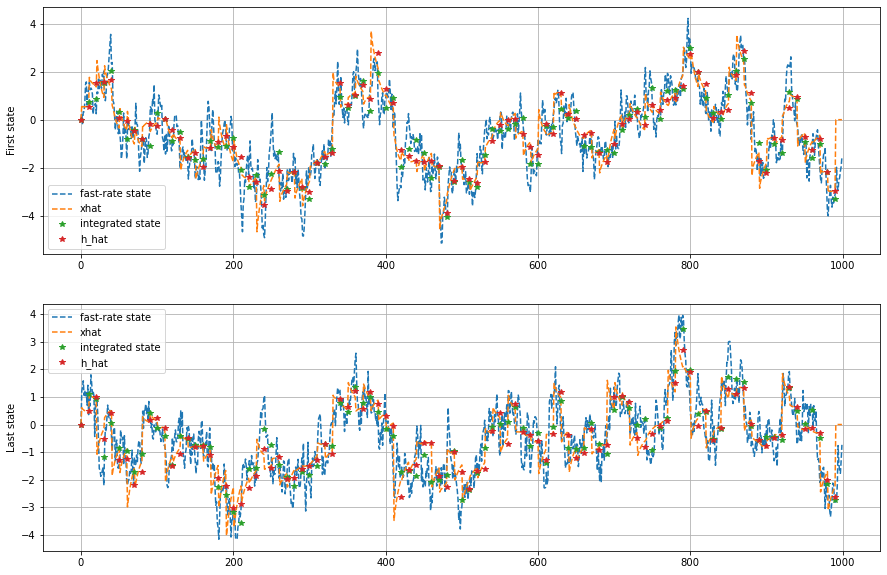

In [8]:
plt.figure(figsize = (15,10))

plt.subplot(211)
plt.plot(x[:,0],'--',label = 'fast-rate state')
plt.plot(x_hat[:,0],'--',label = 'xhat')
plt.plot(np.arange(0,T,l),h[:,0],'*',label = 'integrated state')
plt.plot(np.arange(0,T,l),h_hat[:,0],'*',label = 'h_hat')
plt.ylabel('First state')
plt.legend()
plt.grid()

plt.subplot(212)
plt.plot(x[:,3],'--',label = 'fast-rate state')
plt.plot(x_hat[:,3],'--',label = 'xhat')
plt.plot(np.arange(0,T,l),h[:,3],'*',label = 'integrated state')
plt.plot(np.arange(0,T,l),h_hat[:,3],'*',label = 'h_hat')
plt.ylabel('Last state')
plt.legend()
plt.grid()

# Kalman Filter

In [ ]:
m = x_init
P = cov_init
kf_m = np.zeros((T, m.shape[0]))
kf_P = np.zeros((T, P.shape[0], P.shape[1]))
for n in range(T):
    # Prediction
    m = A @ m
    P = A @ P @ A.T + Q
    # Update
    S = C @ P @ C.T + R
    K = P @ C.T @ linalg.inv(S)
    m = m + K @ (Y[n] - C @ m)
    P = P - K @ S @ K.T
    kf_m[n,:] = m
    kf_P[n,:,:] = P

# Parallel integrated state estimation

In [9]:
#filtering
a = kf.filteringInitializer(A_bar, Q_M, C, R, y, x_init, cov_init, T,l)
kf_res = kf.parallelScanAlgorithm(a, T, kf.filtering)

KF_m = []
KF_P = []
for k in range(l,len(kf_res),l): 
    KF_m.append(kf_res[k]['b'])
    KF_P.append(kf_res[k]['C'])
kf_m = np.array(KF_m).reshape(-1,4)

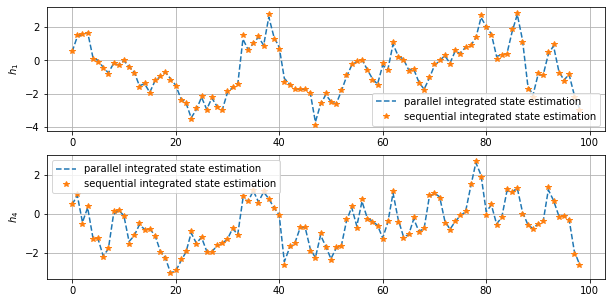

In [10]:

plt.figure(figsize = (10,5))
plt.subplot(211)
plt.plot(kf_m[:,0],'--',label = 'parallel integrated state estimation')
plt.plot(h_hat[1:,0], '*', label = 'sequential integrated state estimation')
plt.ylabel('$h_1$')
plt.legend()
plt.grid()

plt.subplot(212)
plt.plot(kf_m[:,3],'--',label = 'parallel integrated state estimation')
plt.plot(h_hat[1:,3], '*', label = 'sequential integrated state estimation')
plt.ylabel('$h_4$')
plt.legend()
plt.grid()

In [11]:
kf_m[:,3]

array([ 0.47443408,  0.95048334, -0.42692253,  0.31848305, -1.18564189,
       -1.26605187, -2.14285762, -1.78955858, -0.02654727,  0.19196063,
       -0.08833395, -1.40981781, -1.11145315, -0.54838854, -0.78669248,
       -0.77894589, -1.0749075 , -1.87103598, -2.23009761, -2.99785545,
       -2.92348804, -2.40994329, -1.94688032, -0.96950443, -1.49261484,
       -1.19754538, -1.90023667, -1.91951955, -1.63126781, -1.50134609,
       -1.28935913, -0.7483352 , -1.0465387 ,  0.78509474,  0.63619346,
        1.18102972,  0.61050118,  1.11763482,  0.77280672,  0.31357307,
       -0.04381299, -2.43588659, -1.74029434, -1.5080685 , -0.75117566,
       -0.668894  , -1.77066233, -2.2352049 , -1.08280981, -1.65303263,
       -2.28716904, -1.75664464, -1.6423227 , -0.36720895,  0.34055092,
       -0.62274146,  0.63868867, -0.19551973, -0.36621669, -0.58421483,
       -1.23056614, -0.42636932,  1.06030447, -0.28702744, -1.14491682,
       -1.07548765, -0.25455102, -0.89180587, -0.74746   ,  0.85

In [12]:
h_hat[1:,3]

array([ 0.49705591,  0.99155983, -0.53858794,  0.40463183, -1.28496198,
       -1.2510767 , -2.18605851, -1.72110021,  0.15624885,  0.22381677,
       -0.11776578, -1.52126415, -1.06981582, -0.48285719, -0.81202959,
       -0.78401027, -1.11227204, -1.93580775, -2.23825438, -3.02285391,
       -2.86780139, -2.31804441, -1.88011152, -0.87637721, -1.55970075,
       -1.19053526, -1.9650892 , -1.92908006, -1.59888364, -1.49299879,
       -1.2830768 , -0.7031352 , -1.07570707,  0.93670085,  0.63892132,
        1.22214875,  0.55473733,  1.16311385,  0.73573846,  0.2947778 ,
       -0.06076563, -2.62391139, -1.65934632, -1.46360375, -0.67548994,
       -0.66516024, -1.87408992, -2.272066  , -0.99592323, -1.70945114,
       -2.33923344, -1.70250351, -1.62873677, -0.25065821,  0.40282412,
       -0.71064625,  0.74987851, -0.26940269, -0.39059925, -0.61299802,
       -1.29638326, -0.34102872,  1.19298258, -0.39734031, -1.21583252,
       -1.04821299, -0.16746574, -0.93971391, -0.73929875,  0.98